<a href="https://colab.research.google.com/github/mmonch/Sidecar_Project/blob/main/notebooks/Sidecar_Project_lstm_seq2seq_model_full_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id='Q0'></a>
<center><a target="_blank" href="https://sit.academy/"><img src="https://drive.google.com/uc?id=1z0U84GYqhbWWpCenFajh8_8XFRGyOc3U" width="200" style="background:none; border:none; box-shadow:none;" /></a> </center>
<center> <h1> Notebook 3: Character-level LSTM Seq2Seq  Model </h1> </center>
<p style="margin-bottom:1cm;"></p>
<center><h4>Marlies Monch, SIT Academy, 2022</h4></center>
<p style="margin-bottom:1cm;"></p>

<div style="background:#EEEDF5;border-top:0.1cm solid #EF475B;border-bottom:0.1cm solid #EF475B;">
    <div style="margin-left: 0.5cm;margin-top: 0.5cm;margin-bottom: 0.5cm;color:#303030">
        <p><strong>Goal:</strong> Run a character-level seq2seq model (RNN) on the Attribute Technical Names to match the Attribute Business Names</p>
        <strong> Outline:</strong>
        <a id='P0' name="P0"></a>
        <ol>
            <li> <a style="color:#303030" href='#I'>Introduction </a> </li>
            <li> <a style="color:#303030" href='#SU'>Set up</a></li>
            <li> <a style="color:#303030" href='#DA'>Dataset </a></li>
            <li> <a style="color:#303030" href='#PP'>Preparing the Data</a></li>
            <li> <a style="color:#303030" href='#BT'>Build and Train Model</a></li>
            <li> <a style="color:#303030" href='#IN'>Training Data Inference</a></li>
            <li> <a style="color:#303030" href='#VA'>Test Data Performance</a></li>
            <li> <a style="color:#303030" href='#TI'>Test Data Inference</a></li>
            <li> <a style="color:#303030" href='#CO'>Conclusion</a></li>
        </ol>
        <strong>Keywords:</strong> RNN, seq2seq, NLP, Attribute Business Name, Sidecar Project
    </div>
</div>
</nav>

<a id='I' name="I"></a>
## [Introduction](#P0)

Source: https://keras.io/examples/nlp/lstm_seq2seq/
https://towardsdatascience.com/character-level-language-model-1439f5dd87fe

This notebook guides you through training, evaluation and interpretation of the character-level RNN to generate Attribute Business Names from Attribute Technical Names. 

As a stringent test of accuracy, we will use Fuzzy Ratios, more information on fuzzy ratios can be found here:

https://www.analyticsvidhya.com/blog/2021/07/fuzzy-string-matching-a-hands-on-guide/

and here:

https://pypi.org/project/fuzzywuzzy/

<a id='SU' name="SU"></a>
## [Set up](#P0)

In [ ]:
# necessary package installations
!pip install contractions
!pip install fuzzywuzzy[speedup]

In [ ]:
# nlp packages
import re
import unicodedata
import contractions
import spacy
import nltk
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# progressbar
import tqdm

# general packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ML/Deep learing
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
# fix random seed for reproducibility
seed = 42

# for numpy
np.random.seed(seed)
# for tenserflow.keras
tf.random.set_seed(seed)

<a id='DA' name="DA"></a>
## [Dataset](#P0)

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# load dataset
data = pd.read_csv("gdrive/My Drive/SIDECAR_P/data/Sidecar_Data_Sample.csv")
len(data)

4133

In [ ]:
# optional:
# Use subset of most common Attribute Business Name types
# top_n= data.Attribute_Business_Name.value_counts()[:100]
# find and replace data with top_n_df
# top_n_df = data[data['Attribute_Business_Name'].map(data['Attribute_Business_Name'].value_counts()).isin(top_n)]

In [ ]:
# If you want to run it with only the top 100 indices
# top_n_df = len(data[data['Attribute_Business_Name'].isin(data['Attribute_Business_Name'].value_counts()[:100].index)])

In [ ]:
# Clean P_AF18XXXX from dataset for performance
# this will remove XXX rows of data
data = data[data['Attribute_Technical_Name'].str.contains("P_AF")==False]
len(data)

<a id='SU' name="SU"></a>
## [Set up](#P0)

### Train Test Split

In [ ]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
print("Length of Training Set: " + str(len(train)), "\nLength of Test Set: " + str(len(test)))

Length of Training Set: 3152 
Length of Test Set: 789


### Configurations

In [ ]:
# for plotting
plt.style.use("seaborn")

In [ ]:
# for lstm seq 2 seq model
batch_size = 64  # Batch size for training.
epochs = 200  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.

<a id='PP' name="PP"></a>
## [Preparing the Data](#P0)

### Preprocess and normalize the data


In [ ]:
# preprocess and normalize Text

# in case text not english
def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

# preprocessing
def pre_process_text(labels):
  norm_docs = []
  for string in tqdm.tqdm(labels):
    string = string.replace("_", " ")
    string = string.replace("\n", "").replace("\t","").replace("\r", "")
    string = remove_accented_chars(string) 
    # and inset a space where a number follows a letter et vice versa
    string = re.sub(r'(?<=\d)(?=[^\d\s])|(?<=[^\d\s])(?=\d)', ' ', string)
    # insert space where an uppercase letter follows a lowercase letter
    string = re.sub(r"(?<![A-Z\W])(?=[A-Z])", " ", string)
    string = contractions.fix(string)
    string = string.replace("-", " to ")
    # remove special characters or whitespaces
    string = re.sub(r"[^a-zA-Z0-9\s]", "", string, flags=re.I|re.A)
    string = string.lower()
    string = string.strip()
    # optional: 
    # string = string.split(" ")
    norm_docs.append(string)
  return norm_docs

### Vectorize the Data

In [ ]:
# vectorize the data

input_texts = pre_process_text(train["Attribute_Technical_Name"])
target_texts = ["\t" + s + "\n" for s in pre_process_text(train["Attribute_Business_Name"])]
input_characters = set()
target_characters = set()
for input_name, target_name in zip(input_texts, target_texts):
  for char in input_name:
    if char not in input_characters:
      input_characters.add(char)
  for char in target_name:
    if char not in target_characters:
      target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

100%|██████████| 3152/3152 [00:00<00:00, 48994.19it/s]


Number of samples: 3152
Number of unique input tokens: 37
Number of unique output tokens: 39
Max sequence length for inputs: 41
Max sequence length for outputs: 105


<a id='BT' name="BT"></a>
## [Build and Train Model](#P0)

### Model Compilation and Training

In [ ]:
# define an input sequence and process it
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# we discard "encoder_outputs" and only keep the states
encoder_states = [state_h, state_c]

# set up the decoder, using "encoder_states" as initial state
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well 
# We don't use the return states in the training model, but we will use them in 
# inference
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# "encoder_input_data" & "decoder_input_data" into "decoder_target_data"
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
# Define Metrics
METRICS = [
  "accuracy",
]

In [ ]:
# Compile Keras Model
model.compile(
    optimizer="rmsprop", 
    loss="categorical_crossentropy", 
    metrics=METRICS,
    run_eagerly=True
)

# Callbacks
mc = keras.callbacks.ModelCheckpoint(
    'my_nmt_model_min_loss.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    mode='min'
)
    
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Save training history
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=[mc, es]
)

# Save model
model.save("/content/gdrive/MyDrive/SIDECAR_P/lstm_s2s_v3")

Epoch 1/200
40/40 [==============================] - ETA: 0s - loss: 1.1309 - accuracy: 0.7606
Epoch 1: val_loss improved from inf to 0.84189, saving model to my_nmt_model_min_loss.h5
40/40 [==============================] - 8s 47ms/step - loss: 1.1309 - accuracy: 0.7606 - val_loss: 0.8419 - val_accuracy: 0.7961
Epoch 2/200
37/40 [==========================>...] - ETA: 0s - loss: 0.8780 - accuracy: 0.7823
Epoch 2: val_loss improved from 0.84189 to 0.76421, saving model to my_nmt_model_min_loss.h5
40/40 [==============================] - 1s 21ms/step - loss: 0.8729 - accuracy: 0.7823 - val_loss: 0.7642 - val_accuracy: 0.7942
Epoch 3/200
40/40 [==============================] - ETA: 0s - loss: 0.7895 - accuracy: 0.7823
Epoch 3: val_loss improved from 0.76421 to 0.71058, saving model to my_nmt_model_min_loss.h5
40/40 [==============================] - 1s 21ms/step - loss: 0.7895 - accuracy: 0.7823 - val_loss: 0.7106 - val_accuracy: 0.7936
Epoch 4/200
37/40 [==========================>...]

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/SIDECAR_P/lstm_s2s_v3/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/SIDECAR_P/lstm_s2s_v3/assets


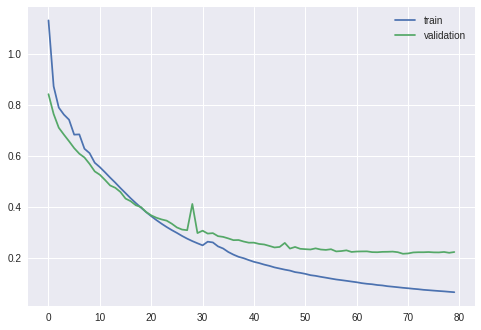

<Figure size 576x396 with 0 Axes>

In [ ]:
# Plot Training Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.savefig("/content/gdrive/MyDrive/SIDECAR_P/loss_lstm_s2s_v3.png")
plt.show()

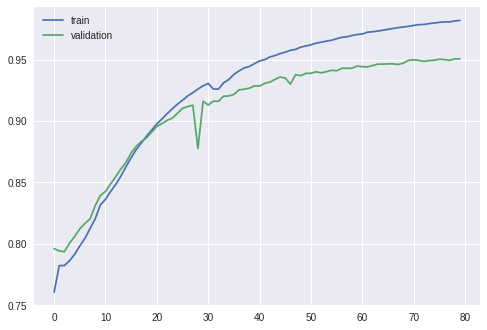

<Figure size 576x396 with 0 Axes>

In [ ]:
# Plot Training Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train','validation'])
plt.savefig("/content/gdrive/MyDrive/SIDECAR_P/accuracy_lstm_s2s_v3.png")
plt.show()

<a id='IN' name="IN"></a>
## [Training Data Inference](#P0)

In [ ]:
# Define sampling models
# Restore the model and construct the encoder and decoder
model = keras.models.load_model("/content/gdrive/MyDrive/SIDECAR_P/lstm_s2s_v3")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1)
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [ ]:
# remove tabs and newlines added in vectorization step
true_target_texts = [string.replace("\t","").replace("\n","") for string in target_texts]

In [ ]:
# save recoding results to a list
results = []
# optional:
# lower range (to 20 or so) to quickly try it on a subset of the data
for seq_index in tqdm.tqdm(range(3306)):
    new_list = []
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    new_list.append(input_texts[seq_index])
    new_list.append(decoded_sentence.replace("\n","").replace("\t",""))
    new_list.append(true_target_texts[seq_index])
    new_list.append(fuzz.ratio(decoded_sentence.replace("\n","").replace("\t",""), true_target_texts[seq_index]))
    new_list.append(fuzz.partial_ratio(decoded_sentence.replace("\n","").replace("\t",""), true_target_texts[seq_index]))
    new_list.append(fuzz.token_sort_ratio(decoded_sentence.replace("\n","").replace("\t",""), true_target_texts[seq_index]))
    results.append(new_list)

 95%|█████████▌| 3152/3306 [1:20:05<03:54,  1.52s/it]


ValueError: ignored

### Guide to Fuzzy Ratios:
- fuzz ratio returns 100% only when there is an exact match.
- fuzz partial ratio checks if either of the strings is a sub string of the other. 
- fuzzy token sort ration ignores punctuation and ignores the order of the words in a string.
- token_set_ratio() takes a more flexible approach than token_sort_ratio(). Instead of just tokenizing the strings, sorting and then pasting the tokens back together, token_set_ratio performs a set operation that takes out the common tokens (the intersection) and then makes fuzz.ratio(). Extra or same repeated words do not matter.

In [ ]:
# Save Inputs, Predictions, Targets and Fuzzy Values 
full_fuzzy_train_df = pd.DataFrame(results, columns=[
                                          "Input",                                   
                                          "Predicted_Output", 
                                          "Target_Output",
                                          "Fuzzy_Ratio",
                                          "Fuzzy_Partial_Ratio",
                                          "Fuzzy_Token_Sort_Ratio"]
                        )

In [ ]:
# save as CSV
full_fuzzy_train_df.to_csv(os.path.join("/content/gdrive/MyDrive/SIDECAR_P","full_fuzzy_train_df.csv"))

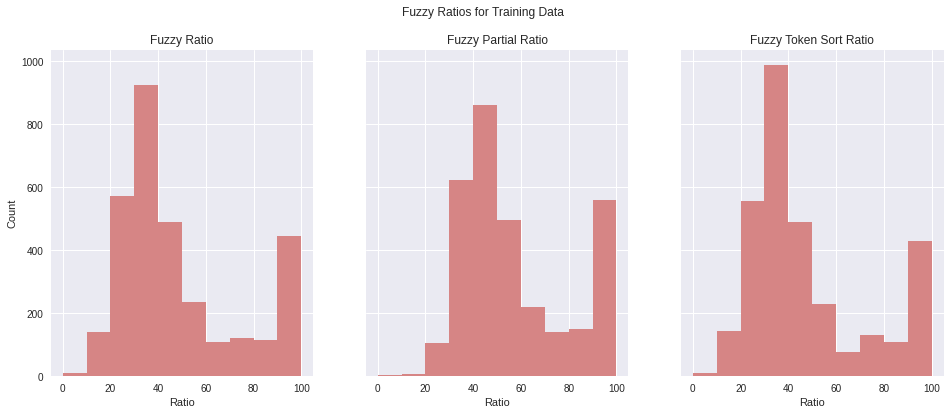

In [ ]:
# define subplot axes
fig, (axs) = plt.subplots(nrows=1, ncols=3, sharey=True)

# set figure title
fig.suptitle('Fuzzy Ratios for Training Data')

# plot histograms
axs[0].hist(full_fuzzy_train_df["Fuzzy_Ratio"], color = "#d68585ff")
axs[1].hist(full_fuzzy_train_df["Fuzzy_Partial_Ratio"], color ="#d68585ff")
axs[2].hist(full_fuzzy_train_df["Fuzzy_Token_Sort_Ratio"], color ="#d68585ff")

# set plot titles
axs[0].set_title('Fuzzy Ratio')
axs[1].set_title('Fuzzy Partial Ratio')
axs[2].set_title('Fuzzy Token Sort Ratio')

# set labels
plt.setp(axs, xlabel='Ratio')
plt.setp(axs[0], ylabel='Count')
fig.set_size_inches(16,6)
plt.savefig("/content/gdrive/MyDrive/SIDECAR_P/full_training_fuzzy_ratios.png")
plt.show()

In [ ]:
full_fuzzy_train_df["Fuzzy_Ratio"].describe()

count    3152.000000
mean       48.238261
std        25.762027
min         0.000000
25%        30.000000
50%        39.000000
75%        59.000000
max       100.000000
Name: Fuzzy_Ratio, dtype: float64

In [ ]:
full_fuzzy_train_df["Fuzzy_Partial_Ratio"].describe()

count    3152.000000
mean       57.090102
std        23.739384
min         0.000000
25%        40.000000
50%        48.000000
75%        74.250000
max       100.000000
Name: Fuzzy_Partial_Ratio, dtype: float64

In [ ]:
full_fuzzy_train_df["Fuzzy_Token_Sort_Ratio"].describe()

count    3152.000000
mean       47.696383
std        25.604382
min         0.000000
25%        30.000000
50%        38.000000
75%        56.000000
max       100.000000
Name: Fuzzy_Token_Sort_Ratio, dtype: float64

In [ ]:
print("Average Partial Fuzzy Ratio:", full_fuzzy_train_df["Fuzzy_Partial_Ratio"].mean())
print("Median Partial Fuzzy Ratio:", full_fuzzy_train_df["Fuzzy_Partial_Ratio"].median())
print("Partial Fuzzy Ratio Mode:", full_fuzzy_train_df["Fuzzy_Partial_Ratio"].mode())

Average Partial Fuzzy Ratio: 57.09010152284264
Median Partial Fuzzy Ratio: 48.0
Partial Fuzzy Ratio Mode: 0    100
dtype: int64


<a id='VA' name="VA"></a>
## [Test Data Performance](#P0)

In [ ]:
# vectorize the data
input_texts = pre_process_text(test["Attribute_Technical_Name"])
target_texts = ["\t" + s + "\n" for s in pre_process_text(test["Attribute_Business_Name"])]
input_characters = set()
target_characters = set()
for input_name, target_name in zip(input_texts, target_texts):
  for char in input_name:
    if char not in input_characters:
      input_characters.add(char)
  for char in target_name:
    if char not in target_characters:
      target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

100%|██████████| 789/789 [00:00<00:00, 57456.22it/s]

{'r', 'y', '2', '7', '3', 'p', '1', 't', 'f', 'a', 'k', 'u', 'l', 'b', 'm', 'x', 'i', 'e', 'j', 'z', '6', 'v', 'c', '0', '8', '9', ' ', 'd', '4', 's', 'q', 'w', 'h', '5', 'g', 'n', 'o'} {'r', 'y', '2', '6', '7', '3', 'p', '1', 't', 'f', 'a', 'k', 'u', 'l', 'b', 'm', 'x', '\n', 'e', 'i', 'j', 'z', 'v', 'c', '0', '8', '9', ' ', 'd', '4', 's', 'q', '\t', 'w', 'h', '5', 'g', 'n', 'o'}
Number of samples: 789
Number of unique input tokens: 37
Number of unique output tokens: 39
Max sequence length for inputs: 39
Max sequence length for outputs: 105


In [ ]:
# Load trained model
model = keras.models.load_model("/content/gdrive/MyDrive/SIDECAR_P/lstm_s2s_v3")

In [ ]:
# Evaluate Model Performance
score, acc = model.evaluate(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size)

print('Test score:', score)
print('Test accuracy:', acc)

13/13 [==============================] - 1s 9ms/step - loss: 0.2396 - accuracy: 0.9442
Test score: 0.23963025212287903
Test accuracy: 0.9442211389541626


<a id='TI' name="TI"></a>
## [Test Data Inference](#P0)

In [ ]:
# remove tabs and newlines added in vectorization step
true_target_texts = [string.replace("\t","").replace("\n","") for string in target_texts]

In [ ]:
# list version
test_results = []
for seq_index in tqdm.tqdm(range(827)):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    new_list = []
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    new_list.append(input_texts[seq_index])
    new_list.append(decoded_sentence.replace("\n","").replace("\t",""))
    new_list.append(true_target_texts[seq_index])
    new_list.append(fuzz.ratio(decoded_sentence.replace("\n","").replace("\t",""), true_target_texts[seq_index]))
    new_list.append(fuzz.partial_ratio(decoded_sentence.replace("\n","").replace("\t",""), true_target_texts[seq_index]))
    new_list.append(fuzz.token_sort_ratio(decoded_sentence.replace("\n","").replace("\t",""), true_target_texts[seq_index]))
    test_results.append(new_list)

 95%|█████████▌| 789/827 [18:11<00:52,  1.38s/it]


ValueError: ignored

In [ ]:
full_fuzzy_test_df = pd.DataFrame(results, columns=[
                                          "Input",                                   
                                          "Predicted_Output", 
                                          "Target_Output",
                                          "Fuzzy_Ratio",
                                          "Fuzzy_Partial_Ratio",
                                          "Fuzzy_Token_Sort_Ratio"]
                        )

In [ ]:
full_fuzzy_test_df

,Input,Predicted_Output,Target_Output,Fuzzy_Ratio,Fuzzy_Partial_Ratio,Fuzzy_Token_Sort_Ratio
0,total domain,total amount excluding tax,total domain,47,67,47
1,transform name,date the product was discontinued,transform name,30,29,30
2,classification code,customers buying group optional,classification code,32,32,28
3,product id,product identification number foreign key to p...,product identification number foreign key to p...,100,100,100
4,application status code,application sme id,application status code,73,72,73
5,classification code,customers buying group optional,classification code,32,32,28
6,step,state province name,step,35,75,26
7,name,number of days ts id,name of the store,49,53,43
8,moins de 05 ans,emp loc city,moins de 5 ans,23,25,31
9,i 2 b 2 request xml,id patient,delete date,48,40,48


In [ ]:
full_fuzzy_train_df.to_csv(os.path.join("/content/gdrive/MyDrive/SIDECAR_P/","full_fuzzy_test_df.csv"))

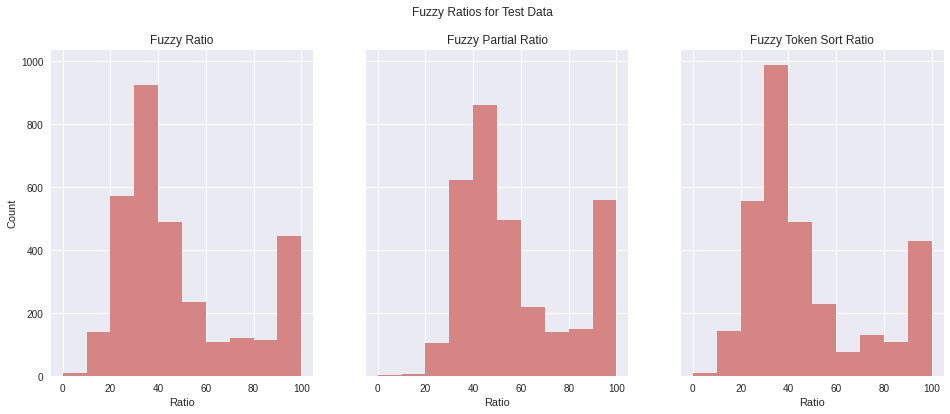

In [ ]:
# define subplot axes
fig, (axs) = plt.subplots(nrows=1, ncols=3, sharey=True)

# set figure title
fig.suptitle('Fuzzy Ratios for Test Data')

# plot histograms
axs[0].hist(full_fuzzy_test_df["Fuzzy_Ratio"], color = "#d68585ff")
axs[1].hist(full_fuzzy_test_df["Fuzzy_Partial_Ratio"], color= "#d68585ff")
axs[2].hist(full_fuzzy_test_df["Fuzzy_Token_Sort_Ratio"], color="#d68585ff")

# set plot titles
axs[0].set_title('Fuzzy Ratio')
axs[1].set_title('Fuzzy Partial Ratio')
axs[2].set_title('Fuzzy Token Sort Ratio')

# set labels
plt.setp(axs, xlabel='Ratio')
plt.setp(axs[0], ylabel='Count')
fig.set_size_inches(16,6)

plt.savefig("/content/gdrive/MyDrive/SIDECAR_P/full_test_fuzzy_ratios.png")

overall very good performance.

### Guide to Fuzzy Ratios:
- fuzz ratio returns 100% only when there is an exact match.
- fuzz partial ratio checks if either of the strings is a sub string of the other. 
- fuzzy token sort ration ignores punctuation and ignores the order of the words in a string.
- token_set_ratio() takes a more flexible approach than token_sort_ratio(). Instead of just tokenizing the strings, sorting and then pasting the tokens back together, token_set_ratio performs a set operation that takes out the common tokens (the intersection) and then makes fuzz.ratio(). Extra or same repeated words do not matter.

In [ ]:
print("Average Fuzzy Ratio:", full_fuzzy_test_df["Fuzzy_Ratio"].mean())
print("Median Fuzzy Ratio:", full_fuzzy_test_df["Fuzzy_Ratio"].median())
print("Fuzzy Ratio Mode:", full_fuzzy_test_df["Fuzzy_Ratio"].mode())

Average Fuzzy Ratio: 48.2382614213198
Median Fuzzy Ratio: 39.0
Fuzzy Ratio Mode: 0    100
dtype: int64


In [ ]:
full_fuzzy_test_df["Fuzzy_Ratio"].describe()

count    3152.000000
mean       48.238261
std        25.762027
min         0.000000
25%        30.000000
50%        39.000000
75%        59.000000
max       100.000000
Name: Fuzzy_Ratio, dtype: float64

### Highest Quantile Fuzzy Ratios



In [ ]:
full_fuzzy_test_df[full_fuzzy_test_df.Fuzzy_Ratio > full_fuzzy_test_df.Fuzzy_Ratio.quantile(.25)]

,Input,Predicted_Output,Target_Output,Fuzzy_Ratio,Fuzzy_Partial_Ratio,Fuzzy_Token_Sort_Ratio
0,total domain,total amount excluding tax,total domain,47,67,47
2,classification code,customers buying group optional,classification code,32,32,28
3,product id,product identification number foreign key to p...,product identification number foreign key to p...,100,100,100
4,application status code,application sme id,application status code,73,72,73
5,classification code,customers buying group optional,classification code,32,32,28
6,step,state province name,step,35,75,26
7,name,number of days ts id,name of the store,49,53,43
9,i 2 b 2 request xml,id patient,delete date,48,40,48
10,property id,property id,property id,100,100,100
11,supplier invoice number,supplier reference for our organization might ...,supplier invoice number if applicable,45,51,45


In [ ]:
#s=fuzzy_test_df.loc[1, "Predicted_Output"]
#":".join("{:02x}".format(ord(c)) for c in s)

In [ ]:
full_fuzzy_test_df[full_fuzzy_test_df.Fuzzy_Partial_Ratio < full_fuzzy_test_df.Fuzzy_Partial_Ratio.quantile(.15)]

,Input,Predicted_Output,Target_Output,Fuzzy_Ratio,Fuzzy_Partial_Ratio,Fuzzy_Token_Sort_Ratio
1,transform name,date the product was discontinued,transform name,30,29,30
2,classification code,customers buying group optional,classification code,32,32,28
5,classification code,customers buying group optional,classification code,32,32,28
8,moins de 05 ans,emp loc city,moins de 5 ans,23,25,31
47,quantity,first name,quantity,22,25,22
49,attribute is pk,attribute id,is primary key,23,25,31
86,attribute is deleted,attribute id,is deleted flag,30,33,30
93,manufacturer,first name,manufacturer,27,30,27
110,inst edu afect,invoice date for this invoice,schools affected,27,31,36
111,host age at collection,import date,age of host,27,27,45


### Lowest Quantile Fuzzy Ratios

In [ ]:
full_fuzzy_test_df[full_fuzzy_test_df.Fuzzy_Ratio < full_fuzzy_test_df.Fuzzy_Ratio.quantile(.25)]

,Input,Predicted_Output,Target_Output,Fuzzy_Ratio,Fuzzy_Partial_Ratio,Fuzzy_Token_Sort_Ratio
8,moins de 05 ans,emp loc city,moins de 5 ans,23,25,31
17,join prop value,number of troop contributing countries 1c,join prop value,29,40,29
31,deaths,date the component storped being sourt destrine d,deaths,18,50,15
34,update date,primary key for product sarceited recrodd s lo...,update date,15,45,17
40,expiration,date that this prical aase,expiration,22,40,33
42,delivery temp,description of the item supplied usually the s...,delivery temp,21,38,19
43,error log id,import date,primary key for error log records,27,45,27
47,quantity,first name,quantity,22,25,22
49,attribute is pk,attribute id,is primary key,23,25,31
53,domain id,number of days ts id the ford id,domain id,29,44,29


In [ ]:
full_fuzzy_test_df["Fuzzy_Ratio"].describe()

count    3152.000000
mean       48.238261
std        25.762027
min         0.000000
25%        30.000000
50%        39.000000
75%        59.000000
max       100.000000
Name: Fuzzy_Ratio, dtype: float64

In [ ]:
full_fuzzy_test_df["Fuzzy_Partial_Ratio"].describe()

count    3152.000000
mean       57.090102
std        23.739384
min         0.000000
25%        40.000000
50%        48.000000
75%        74.250000
max       100.000000
Name: Fuzzy_Partial_Ratio, dtype: float64

In [ ]:
full_fuzzy_train_df["Fuzzy_Token_Sort_Ratio"].describe()

count    3152.000000
mean       47.696383
std        25.604382
min         0.000000
25%        30.000000
50%        38.000000
75%        56.000000
max       100.000000
Name: Fuzzy_Token_Sort_Ratio, dtype: float64

In [ ]:
full_fuzzy_test_df[full_fuzzy_test_df.Fuzzy_Partial_Ratio < full_fuzzy_test_df.Fuzzy_Partial_Ratio.quantile(.25)]

,Input,Predicted_Output,Target_Output,Fuzzy_Ratio,Fuzzy_Partial_Ratio,Fuzzy_Token_Sort_Ratio
1,transform name,date the product was discontinued,transform name,30,29,30
2,classification code,customers buying group optional,classification code,32,32,28
5,classification code,customers buying group optional,classification code,32,32,28
8,moins de 05 ans,emp loc city,moins de 5 ans,23,25,31
25,package type id,property id,type of package received,40,36,34
42,delivery temp,description of the item supplied usually the s...,delivery temp,21,38,19
46,transaction date,total amount excluding tax,date and time of the transaction,34,38,38
47,quantity,first name,quantity,22,25,22
49,attribute is pk,attribute id,is primary key,23,25,31
71,lockout enabled,property id,lockout enabled,31,36,31


<a id='CO' name="CO"></a>
## [Conclusion](#P0)

In sum, the character-level Sequence to Sequence Model shows high Accuracy both of Test and Training Datasets. The lack in size of the Training Dataset becomes apparent in the low Fuzzy Ratios when the model is run on the entire Dataset, and not just the top 100 most frequently used Attribute Business Names.
Performance can be increased by:
- finding more data for rarely occuring terms (such as descriptions in french etc.) and
- coming up with a standard format for Attribute Business Names and thus making the dataset a bit more homogenous

Overall the model shows potential for solving the business problem, but it needs more work before it can be used in a customer environment.

<div style="border-top:0.1cm solid #EF475B"></div>
    <strong><a href='#Q0'><div style="text-align: right"> <h3>End of this Notebook.</h3></div></a></strong>